<h2 style="color:crimson">Ejercicios</h2>

1. Repite el ejemplo *Arxiv ML Papers (I)*, agrega dos nuevas columnas al DataFrame final: `Abstract`, con el resumen de cada paper; `Submitted`, con la fecha en la que fue agregado al sistema. **Hint**: Ambos elementos se encuentran dentro de la *url* encontrada.

----

In [1]:
from requests_html import HTMLSession
import pandas as pd

url = "https://arxiv.org/list/stat.ML/recent"
with HTMLSession() as sess:
    r = sess.get(url)
r
divpage = r.html.find("div[id='dlpage']", first=True)
divpage.find("h1", first=True).text

'Machine Learning'

In [2]:
papers_links = divpage.find("dt")
len(papers_links)

25

In [3]:
papers_titles = divpage.find("dd")
len(papers_titles)

25

In [4]:
def get_abstract(url):
    with HTMLSession() as sess:
        r2 = sess.get(url)
    divpage2 = r2.html.find("div[id='content']", first=True)
    abstract = divpage2.find("blockquote[class='abstract mathjax']", first=True).text
    submitted_date = divpage2.find("div[class='dateline']", first=True).text[13:-1]
    return abstract , submitted_date

In [5]:
values = []
abstract = []
for link_secc, title_secc in zip(papers_links, papers_titles):
    title = title_secc.find("div[class='list-title mathjax']", first=True).text
    
    abstract_url = link_secc.find("a[title='Abstract']", first=True).absolute_links
    abstract_url, *_ = abstract_url
    abstract, submitted_date = get_abstract(abstract_url)
    values.append([title, abstract_url,abstract,submitted_date])

    

In [6]:
df_values = pd.DataFrame(values, columns=["Title", "URL","Abstract", "Submitted"])
df_values.head()



,Title,URL,Abstract,Submitted
0,Title: PAPRIKA: Private Online False Discovery...,https://arxiv.org/abs/2002.12321,"Abstract: In hypothesis testing, a false disco...",27 Feb 2020
1,Title: MetFlow: A New Efficient Method for Bri...,https://arxiv.org/abs/2002.12253,"Abstract: In this contribution, we propose a n...",27 Feb 2020
2,Title: Semi-supervised Anomaly Detection on At...,https://arxiv.org/abs/2002.12011,Abstract: We propose a simple yet effective me...,27 Feb 2020
3,Title: Fast and Three-rious: Speeding Up Weak ...,https://arxiv.org/abs/2002.11955,Abstract: Weak supervision is a popular method...,27 Feb 2020
4,Title: Max-Affine Spline Insights into Deep Ge...,https://arxiv.org/abs/2002.11912,Abstract: We connect a large class of Generati...,26 Feb 2020


----
2. Por medio de la librería `requests` y el API de AlphaVantage, consigue los precios históricos de las monedas `["MXN", "EUR", "BRL", "ARS", "CHF"]` respecto al dólar (todos los precios deben estar en dólares). Crea un DataFrame con cada colúmna la moneda de referencia:

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>MXN</th>      <th>EUR</th>      <th>BRL</th>      <th>ARS</th>      <th>CHF</th>    </tr>  </thead>  <tbody>    <tr>      <th>2014-11-24</th>      <td>0.0732</td>      <td>1.2438</td>      <td>0.3920</td>      <td>0.1169</td>      <td>1.0342</td>    </tr>    <tr>      <th>2014-11-25</th>      <td>0.0731</td>      <td>1.2473</td>      <td>0.3955</td>      <td>0.1169</td>      <td>1.0370</td>    </tr>    <tr>      <th>2014-11-26</th>      <td>0.0728</td>      <td>1.2507</td>      <td>0.3995</td>      <td>0.1168</td>      <td>1.0401</td>    </tr>    <tr>      <th>2014-11-27</th>      <td>0.0726</td>      <td>1.2458</td>      <td>0.3947</td>      <td>0.1169</td>      <td>1.0363</td>    </tr>    <tr>      <th>2014-11-28</th>      <td>0.0717</td>      <td>1.2451</td>      <td>0.3891</td>      <td>0.1168</td>      <td>1.0351</td>    </tr>  </tbody></table>




In [7]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import alpha_vantage as av
import time
from collections import defaultdict
ALPHA_VANTAGE_KEY="J8BIVNEPCLCBXPSK"
url = "https://www.alphavantage.co"
base_url = "https://www.alphavantage.co/query"
# Cargamos el API Key de Alpha Vantage (es personal)
avkey = ALPHA_VANTAGE_KEY

In [8]:
curr_list_url = "https://www.alphavantage.co/physical_currency_list/"
curr_list = pd.read_csv(curr_list_url).set_index("currency name")
curr_list

,currency code
currency name,
United Arab Emirates Dirham,AED
Afghan Afghani,AFN
Albanian Lek,ALL
Armenian Dram,AMD
Netherlands Antillean Guilder,ANG
...,...
CFP Franc,XPF
Yemeni Rial,YER
South African Rand,ZAR


In [9]:
currencies = ["Mexican Peso", "Euro", "Brazilian Real", "Argentine Peso","Swiss Franc"]
target_curr = curr_list.filter(currencies, axis=0)
target_curr
len(target_curr["currency code"].values)

5

In [10]:
r =[]
for i in range(len(target_curr["currency code"].values)):
    daily = {
        "function": "FX_DAILY",
        "to_symbol": "USD",
        "from_symbol": target_curr["currency code"].values[i],
        "apikey": avkey,
        "outputsize": "full"
    }
    r.append(requests.get(base_url, params=daily))
    time.sleep(90)
r

[<Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>]

In [11]:
for i in range(len(target_curr["currency code"].values)):
    data=r[i].json()
    if (i==0):
        df_data = (pd.DataFrame(data["Time Series FX (Daily)"], dtype=float).T.sort_index()
                   .rename({'4. close':target_curr["currency code"].values[i]}, axis = 1)
                   .drop(['1. open','2. high','3. low'], axis = 1)
                   
                  )
        df_data.index = pd.to_datetime(df_data.index)
    else:        
        df_data2 = (pd.DataFrame(data["Time Series FX (Daily)"], dtype=float).T.sort_index()
                   .rename({'4. close':target_curr["currency code"].values[i]}, axis = 1)
                    .drop(['1. open','2. high','3. low'], axis = 1)
                   )
        df_data2.index = pd.to_datetime(df_data2.index)
        df_data = pd.merge(df_data,df_data2, right_index=True ,left_index=True)

df_data

,MXN,EUR,BRL,ARS,CHF
2014-11-07,0.0737,1.2454,0.3902,0.1170,1.0341
2014-11-09,0.0738,1.2462,0.3894,0.1170,1.0359
2014-11-10,0.0734,1.2424,0.3933,0.1170,1.0328
2014-11-11,0.0735,1.2473,0.3894,0.1170,1.0364
2014-11-12,0.0737,1.2428,0.3890,0.1170,1.0337
...,...,...,...,...,...
2020-02-25,0.0523,1.0880,0.2274,0.0157,1.0243
2020-02-26,0.0518,1.0882,0.2242,0.0157,1.0233
2020-02-27,0.0512,1.1002,0.2224,0.0156,1.0323
2020-02-28,0.0510,1.1029,0.2230,0.0156,1.0353


----
3. Con el DataFrame creado en el ejercicio 2, crea el siguiente mapa de calor con la correlación entre cada una de las monedas. **hint**: Revisa que métodos tiene un DataFrame para crear correlaciones; considera la librería `seaborn`.

![](../files/lec04/imgs/heatmap.png)


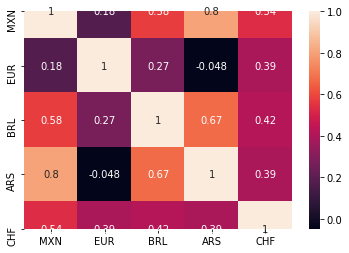

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.heatmap(df_data.corr(), annot=True)


---

4. Con el DataFrame creado en el ejercicio 2, crea un nuevo DataFrame que incluya una correlación móvil con ventana de 30 días de cada una de las monedas respecto a `"MXN"`. **hint**: Investiga sobre el método `.xs` de un DataFrame

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>EUR</th>      <th>BRL</th>      <th>ARS</th>      <th>CHF</th>    </tr>  </thead>  <tbody>    <tr>      <th>2015-03-19</th>      <td>0.900941</td>      <td>0.870440</td>      <td>0.835029</td>      <td>0.916637</td>    </tr>    <tr>      <th>2015-03-20</th>      <td>0.874866</td>      <td>0.815453</td>      <td>0.762308</td>      <td>0.903594</td>    </tr>    <tr>      <th>2015-03-22</th>      <td>0.866783</td>      <td>0.789977</td>      <td>0.726098</td>      <td>0.900547</td>    </tr>    <tr>      <th>2015-03-23</th>      <td>0.835823</td>      <td>0.728781</td>      <td>0.643129</td>      <td>0.885424</td>    </tr>    <tr>      <th>2015-03-24</th>      <td>0.801267</td>      <td>0.671188</td>      <td>0.560149</td>      <td>0.877682</td>    </tr>  </tbody></table>


In [13]:
mov_correl = df_data.rolling(30).corr()
df_movil_correl = mov_correl.xs('MXN',level=1,drop_level=True).drop('MXN',axis = 1)
df_movil_correl.loc['2015-03-19':'2015-03-24',:]

,EUR,BRL,ARS,CHF
2015-03-19,0.900941,0.870440,0.835029,0.916637
2015-03-20,0.874866,0.815453,0.762308,0.903594
2015-03-22,0.866783,0.789977,0.726098,0.900547
2015-03-23,0.835823,0.728781,0.643129,0.885424
2015-03-24,0.801267,0.671188,0.560149,0.877682


---

5. Con el DataFrame creado en el ejercicio 4, crea la siguiente figura con _scatterplots_ entre todas las combinaciones de las correlaciones respecto a `"MXN"`. 

![](../files/lec04/imgs/scatter.png)


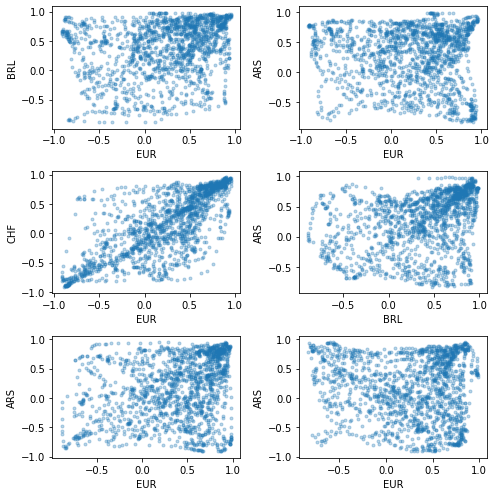

In [14]:

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7, 7))
axes[0,0].scatter(df_movil_correl['EUR'],df_movil_correl['BRL'],marker='.',alpha=0.3)
axes[0,0].set_xlabel('EUR')
axes[0,0].set_ylabel('BRL')
axes[0,1].scatter(df_movil_correl['EUR'],df_movil_correl['ARS'],marker='.',alpha=0.3)
axes[0,1].set_xlabel('EUR')
axes[0,1].set_ylabel('ARS')
axes[1,0].scatter(df_movil_correl['EUR'],df_movil_correl['CHF'],marker='.',alpha=0.3)
axes[1,0].set_xlabel('EUR')
axes[1,0].set_ylabel('CHF')
axes[1,1].scatter(df_movil_correl['BRL'],df_movil_correl['ARS'],marker='.',alpha=0.3)
axes[1,1].set_xlabel('BRL')
axes[1,1].set_ylabel('ARS')
axes[2,0].scatter(df_movil_correl['BRL'],df_movil_correl['CHF'],marker='.',alpha=0.3)
axes[2,0].set_xlabel('EUR')
axes[2,0].set_ylabel('ARS')
axes[2,1].scatter(df_movil_correl['ARS'],df_movil_correl['CHF'],marker='.',alpha=0.3)
axes[2,1].set_xlabel('EUR')
axes[2,1].set_ylabel('ARS')

fig.tight_layout()



¿Encuentras algún patrón en alguna combinación? 

En la combinacióm de Euro y Franco Suizo es casi lineal. En cada combinación existe una correlación muy marcada excepto en la combinación ARS y CHF, donde hay una mayor dispersión de la información

---

6. Con el DataFrame creado en el ejercicio 4, crea la siguiente figura, la cuál representa, a cada observación, la correlación promedio entre todas las monedas respecto a `"MXN"` y unas bandas que representan la correlación máxima y mínima a cada observación.

![](../files/lec04/imgs/corr_ts.png)

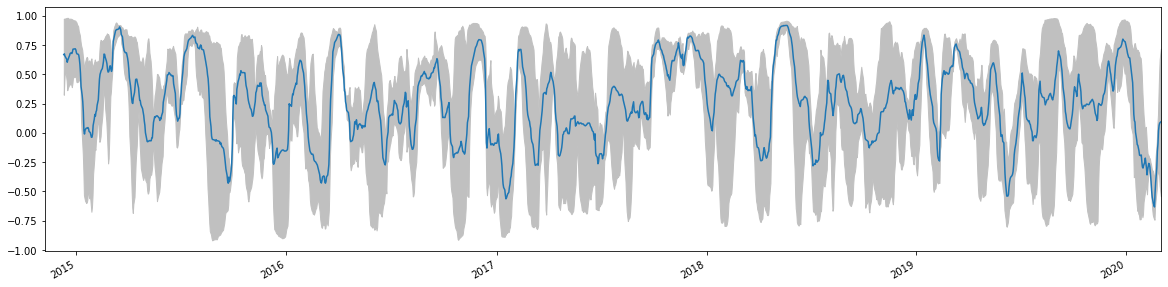

In [15]:
plt.rcParams["figure.figsize"] = (20,5)

df_movil_correl.mean(axis=1).plot()
plt.fill_between(x=df_movil_correl.index,y1=df_movil_correl.min(axis=1),y2=df_movil_correl.max(axis=1), color='silver')
